Find Players with low potentials but high actual Rating
- Label Players has a potential higher than 83 but never reaches this potential

In [1]:
HYPERTRAINING = False
CV = 5
SCORING = 'r2'
AUTO_FEATURE_SELECT = 'backward'
# forward eher schlecht
#'neg_mean_squared_error'   nope
#r2 sehr gut -> 0.45
# 'explained_variance'
# HUBER
if SCORING in ['neg_mean_squared_error']:
    DIRECTION = "minimize"
else:
    DIRECTION = "maximize"
TRIALS = 30    
CLASS_WEIGHTS = 'balanced'
EXPERIEMENT_NAME = "potential_defense_midfielder"
SAVE_MODEL_NAME = EXPERIEMENT_NAME
RUN_NAME = None
TARGET_OVERALL = 80

PLAYER_ATTRIBUTES = [  'central','offense','Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackle','shooting_technique', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking']


PLAYER_ATTRIBUTES = [  'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',  'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
                      'StandingTackle','shooting_technique', 'SlidingTackle']



In [2]:
import os
import pandas as pd
import numpy as np
import sys
import os

def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")
find_and_append_module_path()
os.getcwd()

from src.sport_analytics.model.prepare import add_features_raw_datadf_raw
from src.sport_analytics.model.eval import plot_feature_importance,plot_shap_summary,plot_auc_curves
import config as CONFIG

New current directory: c:\Users\Robert\Documents\Projekte\dev\statsfaction


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Get Data

In [3]:
sql_prime = """
SELECT max(Age) as prime_age,* FROM(SELECT MAX(Overall) AS PrimeOverall,*
  FROM fifa
  GROUP BY ID ) 
  GROUP BY ID
  order by PrimeOverall DESC;
"""

sql_potentials = f"""
SELECT min(Age) as potential_age,* FROM  (SELECT *,Potential as max_potential FROM fifa WHERE Potential>={TARGET_OVERALL})
GROUP BY ID
order by potential DESC;
"""



In [4]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import sqlite3
DATABASE_PATH = "data/sport_analytics/database/football.db"
# Step 1: Establish a database connection
conn = sqlite3.connect(DATABASE_PATH)

df_potentials = pd.read_sql_query(sql_potentials, conn)
df_prime = pd.read_sql_query(sql_prime, conn)

conn.close()

df_potentials = df_potentials.set_index(['ID'])
df_prime = df_prime.set_index(['ID'])

df_raw = df_potentials.join(df_prime[["prime_age","PrimeOverall"]])
df_raw = df_raw.reset_index(['ID'])
df_raw = add_features_raw_datadf_raw(df_raw)

df_raw.head()


,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,age_based_Reactions,age_based_Dribbling,age_based_physique,age_based_shooting_technique,age_based_Stamina,age_based_Positioning,age_based_Vision,age_based_Finishing,age_based_BallControl,age_based_shooting
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,...,17.502664,31.843694,-3.713144,29.699822,2.902309,31.346359,27.808171,36.721137,27.376554,33.410894
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,...,13.717460,28.879365,9.719048,32.160635,11.850794,28.977778,15.171429,34.958730,26.241270,33.225397
244778,Trincão,2021,20.0,20.0,https://cdn.sofifa.net/players/244/778/21_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,78.0,91.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€34M,...,12.830986,20.380282,8.190781,16.056082,9.382843,16.982074,15.554417,20.797695,15.592830,15.660265
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,...,14.938728,19.894798,2.326590,19.198382,9.764162,23.989595,23.932948,24.187283,20.012717,22.174181
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,...,14.938728,19.894798,0.326590,20.598382,16.764162,26.989595,12.932948,26.187283,14.012717,26.840848


# 

In [5]:
df = df_raw.copy()

year_to_category = {2011: 'drop', 2012: 'train', 2013: 'train', 2014: 'train', 2015: 'train', 2016: 'train', 2017: 'train', 2018: 'train', 2019: 'train', 2020: 'test', 2021: 'test', 2022: 'valid', 2023: 'valid', 2024: 'valid'}
df['set'] = df.index.get_level_values('FIFA').values
# Apply the mapping to the "FIFA" column
df['set'] = df['set'].map(year_to_category)

df_potentials = df[(df.set=="valid")&(df.Age<26)&(df.Potential>=TARGET_OVERALL)]

In [6]:
df = df[(df.central == 1)&(df.offense == -0.5)]

# Training nur auf High Potentials
df = df[df.max_potential>TARGET_OVERALL]

# nur Entwicklugnsfähige Spieler
df = df[df.prime_age>df.potential_age]
df = df[df.PrimeOverall>df.Overall]
df['target'] = df.PrimeOverall
df = df[df.potential_age<23]

print(df.target.value_counts())
PREDICTION_NAME = "Offense"

df_processed = df.copy()

target
79.0    14
78.0    13
76.0    12
73.0    10
77.0     9
72.0     9
75.0     8
69.0     8
83.0     7
71.0     6
74.0     6
81.0     5
70.0     5
84.0     4
80.0     4
68.0     4
63.0     3
64.0     3
86.0     3
82.0     3
67.0     3
89.0     2
65.0     1
Name: count, dtype: int64


In [7]:
df[["potential_age","Age","prime_age","max_potential","Potential","Overall","PrimeOverall","target","set","best_position"]].head()

,,,potential_age,Age,prime_age,max_potential,Potential,Overall,PrimeOverall,target,set,best_position
ID,Name,FIFA,,,,,,,,,,
241096,S. Tonali,2020,19.0,19.0,23.0,89.0,89.0,75.0,86.0,86.0,test,CDM
208141,Gabriel,2013,18.0,18.0,26.0,88.0,88.0,66.0,79.0,79.0,train,CDM
232270,T. Fosu-Mensah,2017,18.0,18.0,20.0,87.0,87.0,71.0,76.0,76.0,train,CDM
223517,Danilo,2016,19.0,19.0,20.0,87.0,87.0,78.0,79.0,79.0,train,CDM
202642,Fernando,2012,19.0,19.0,25.0,87.0,87.0,70.0,79.0,79.0,train,CDM


In [8]:
# if True:
#     df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
#     df.shape
# else:
#     select_position = lambda x: x in ["ST","CF","LW","RW"]
#     df["select"] = df['Position'].apply(select_position)
#     df = df[df["select"]]
#     df.shape

###  Feature Engineering

In [9]:
df_processed.columns[df_processed.isna().sum()>0]

Index(['Club', 'Marking', 'Composure', 'Defensive awareness', 'mental'], dtype='object')

#### Transform Value

In [10]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

<Axes: >

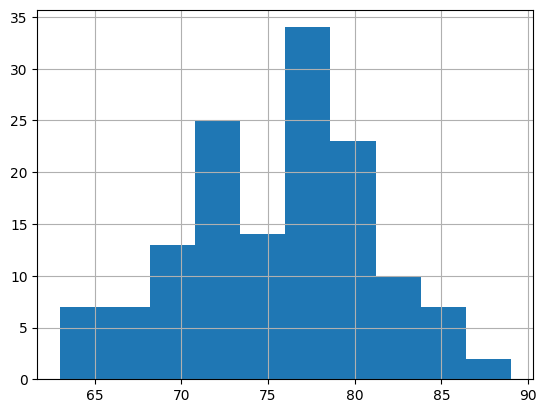

In [11]:
df['target'].hist()

In [12]:
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
# Split the data into training and testing sets

In [13]:
df_processed.columns

Index(['potential_age', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall',
       'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Position', 'Unnamed: 0', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Composure',
       'Defensive awareness', 'max_potential', 'prime_age', 'PrimeOverall',
       'best_position', 'central', 'winger', 'offense', 'Defense',
       'overall_age_ratio', 'youth_player', 'shooting', 'shooting_technique',
       'mental', 'physique', 'Speed', 'ball_handling', 'age_based_Strength',
       'age_based_React

In [14]:


from sklearn.model_selection import train_test_split
if False:
    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train[PLAYER_ATTRIBUTES]
    X_test = X_test[PLAYER_ATTRIBUTES]

else:

    X_train = X[X.set=="train"][PLAYER_ATTRIBUTES]
    y_train = y[X.set=="train"]

    X_test = X[X.set=="test"][PLAYER_ATTRIBUTES]
    y_test = y[X.set=="test"]


In [15]:
y_train.describe()

count    75.000000
mean     76.600000
std       4.929229
min      64.000000
25%      74.000000
50%      77.000000
75%      79.000000
max      89.000000
Name: target, dtype: float64

In [16]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')

import pandas as pd

from sklearn.preprocessing import StandardScaler
# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training 
# and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES].fillna(0))

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=PLAYER_ATTRIBUTES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=PLAYER_ATTRIBUTES)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=PLAYER_ATTRIBUTES)

# Hyperparametertuning

In [17]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.2, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(RandomForestRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RF = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RF)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RF = {}


In [18]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.6, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(GradientBoostingRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_GB = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_GB)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_GB = {}


In [19]:
import optuna
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'alpha': trial.suggest_float('alpha', 0.01, 10.0),
            'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        }

        # Implement cross-validation
        cv_scores = cross_val_score(Ridge(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RIDGE = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RIDGE)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RIDGE = {}


# TODOS
- SHAP Values for Regression Models -> DONE
- SCV and Logistic Regression -> nope
- Hyperparameter Tuning -> nope
- classification model einbauen -> DONE
- Make Usable in Deployment  -> DONE
- Finishing + FKAccuaracy -> Shooting
- Blog umschreiben
- Video machen :)

2023/12/04 12:47:47 INFO mlflow.tracking.fluent: Experiment with name 'potential_defense_midfielder' does not exist. Creating a new experiment.


Ridge Regression training----->


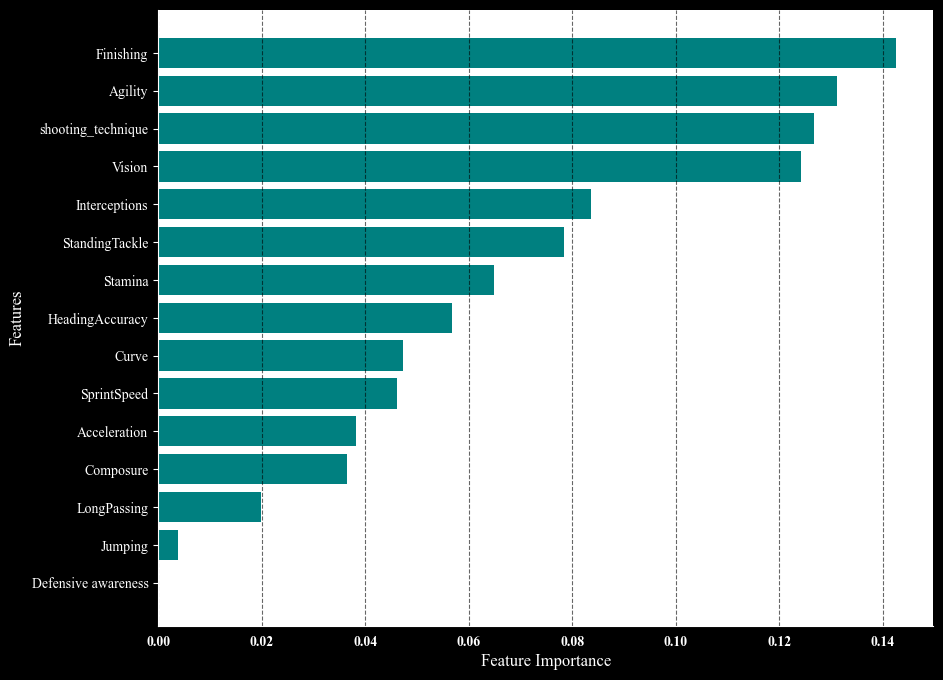

100%|██████████| 30/30 [00:13<00:00,  2.16it/s]


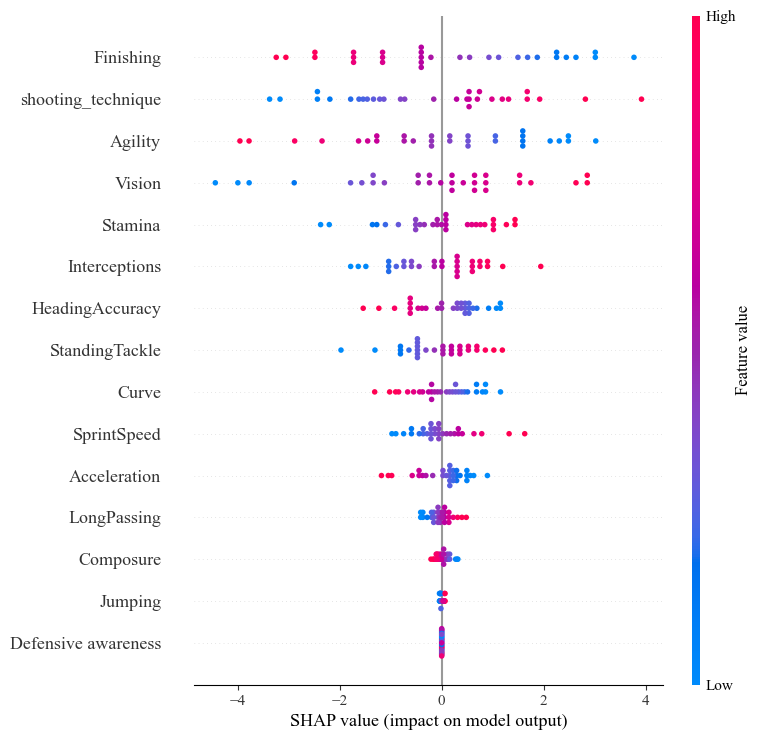

              precision    recall  f1-score   support

       False       0.97      1.00      0.99        33
        True       1.00      0.50      0.67         2

    accuracy                           0.97        35
   macro avg       0.99      0.75      0.83        35
weighted avg       0.97      0.97      0.97        35

Huber Regression training----->


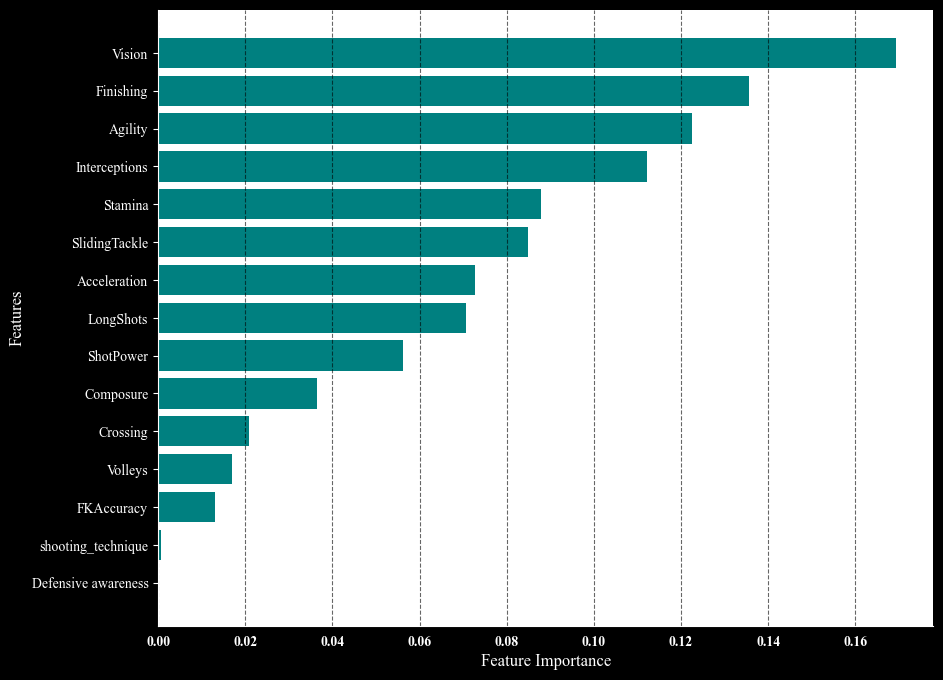

100%|██████████| 30/30 [00:12<00:00,  2.34it/s]


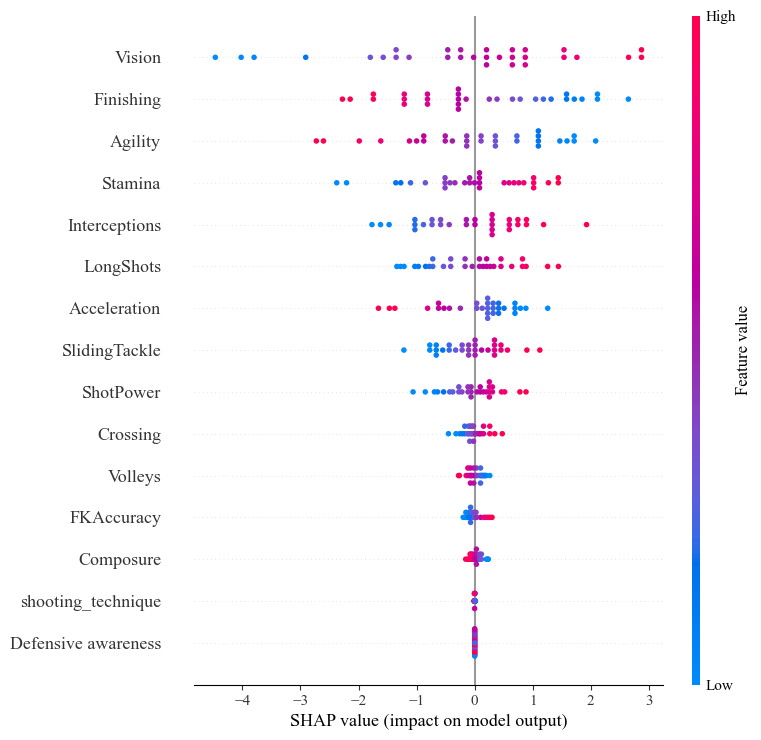

              precision    recall  f1-score   support

       False       0.97      0.97      0.97        33
        True       0.50      0.50      0.50         2

    accuracy                           0.94        35
   macro avg       0.73      0.73      0.73        35
weighted avg       0.94      0.94      0.94        35

Linear Regression training----->


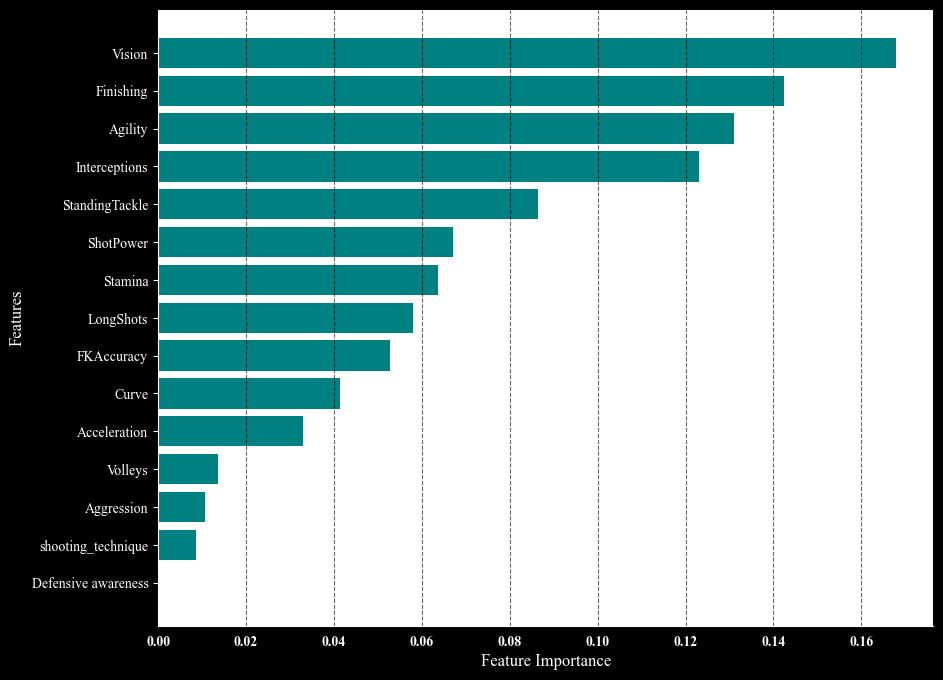

100%|██████████| 30/30 [00:12<00:00,  2.37it/s]


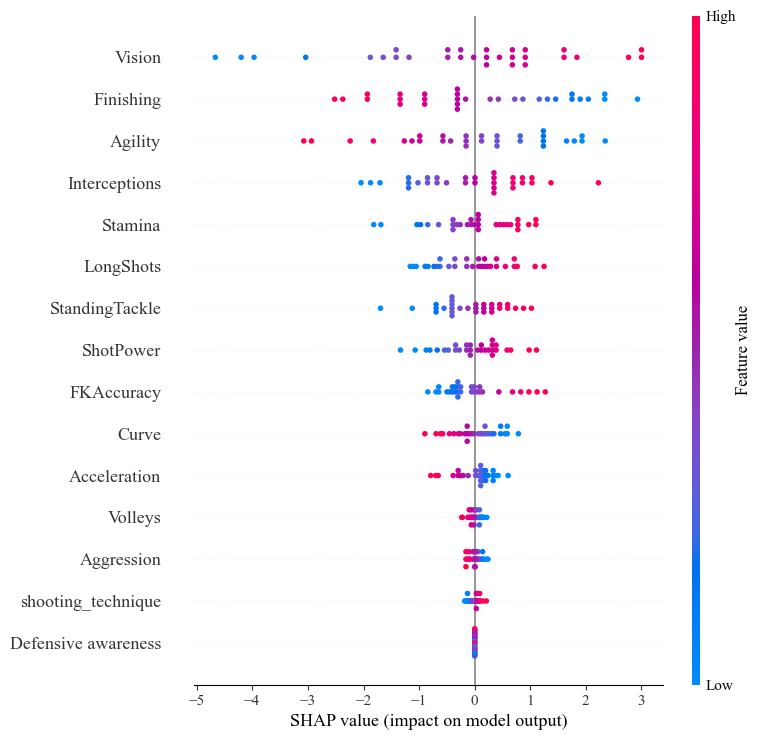

              precision    recall  f1-score   support

       False       0.97      0.97      0.97        33
        True       0.50      0.50      0.50         2

    accuracy                           0.94        35
   macro avg       0.73      0.73      0.73        35
weighted avg       0.94      0.94      0.94        35

Model: Ridge Regression
Mean Squared Error: 17.75
Mean Absolute Error: 3.21
R2 Score: 0.38

Model: Huber Regression
Mean Squared Error: 17.32
Mean Absolute Error: 3.24
R2 Score: 0.40

Model: Linear Regression
Mean Squared Error: 16.97
Mean Absolute Error: 3.18
R2 Score: 0.41



In [20]:
from sklearn.linear_model import LinearRegression,HuberRegressor

from src.sport_analytics.model.eval import plot_feature_importance, log_metrics_in_mlflow_regression,log_metrics_in_mlflow, log_feature_list_as_artifact, plot_shap_summary
from src.sport_analytics.model.prepare import select_features
from src.sport_analytics.utils import *
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import Ridge



regression_models = {
    'Ridge Regression': Ridge(**PARAMS_RIDGE),
    'Huber Regression':HuberRegressor(),
    # 'AdaBoost Regressor': AdaBoostRegressor(random_state=42),

    # 'Lasso Regression': Lasso(),
    # 'ElasticNet Regression': ElasticNet(),
    'Linear Regression': LinearRegression(),
    # 'Random Forest Regressor': RandomForestRegressor(**PARAMS_RF,random_state=42),
    # 'Gradient Boosting Regressor': GradientBoostingRegressor(**PARAMS_GB,random_state=42),
    # 'XGBoost Regressor': xgb.XGBRegressor(random_state=42),
    # 'LightGBM Regressor': lgb.LGBMRegressor(random_state=42)
    # Add more models as needed
}


regression_results = {}
import datetime
# Set the experiment name
mlflow.set_experiment(EXPERIEMENT_NAME)

# Start MLflow run with a specific run name and description
for model_name, model in regression_models.items():
    from datetime import datetime

    # Get the current timestamp
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    with mlflow.start_run(run_name=f"{model_name}_{timestamp}"):

        print(model_name, "training----->")

        # Log parameters
        mlflow.log_param("Model_Name", model_name)
        mlflow.log_params(model.get_params())

        features = select_features(method=AUTO_FEATURE_SELECT,X=X_train_scaled_df,y=y_train,model=model)
        
        model.fit(X_train_scaled_df[features], y_train)
        y_pred = model.predict(X_test_scaled_df[features])
        
        # Log Params
        log_feature_list_as_artifact(PLAYER_ATTRIBUTES, filename="feature_list.txt")

        # Create a dictionary with parameters and their values
        params_to_log = {
            'HYPERTRAINING': HYPERTRAINING,
            'CV': CV,
            'SCORING': SCORING,
            'features_anzahl': len(features),
            'TARGET_OVERALL': TARGET_OVERALL
        }

        # Log parameters using log_params
        mlflow.log_params(params_to_log)

        # Log artifacts
        mlflow.sklearn.log_model(model, model_name)

        # Evaluation Metrics
        log_metrics_in_mlflow_regression(y_test=y_test, y_pred=y_pred,X = X_test_scaled_df[features])
        log_metrics_in_mlflow(y_test=y_test>TARGET_OVERALL,y_prob=None,y_pred=y_pred>TARGET_OVERALL)

        # Evaluation Plots (Note: Regression models may not have ROC curves, so adapt this as needed)
        plot_feature_importance(model, '', top_n=20)
        explainer = plot_shap_summary(model=model,df=X_test_scaled_df[features],K = 30)

        # Output for quick evaluation
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        from sklearn.metrics import  classification_report
        report = classification_report(y_test>TARGET_OVERALL, y_pred>TARGET_OVERALL)
        print(report)

     
        regression_results[model_name] = {
            'Model': model,
            'Scaler': scaler,
            'explainer':explainer,
            'attributes': features,
            'Classification Report': report,
            'Mean Squared Error': mse,
            'Mean Absolute Error': mae,
            'R2 Score': r2
        }

# Evaluate and print results for each model
for model_name, results in regression_results.items():
    print(f"Model: {model_name}")
    print(f"Mean Squared Error: {results['Mean Squared Error']:.2f}")
    print(f"Mean Absolute Error: {results['Mean Absolute Error']:.2f}")
    print(f"R2 Score: {results['R2 Score']:.2f}")
    print()




In [21]:
from src.sport_analytics.model.utils import *
if SAVE_MODEL_NAME!="":
    save_dict_as_pickle(data_dict = regression_results, file_path=f"{CONFIG.TRAINED_MODELS}/{SAVE_MODEL_NAME}.pkl")

# evaluate Model

In [22]:
X_train.describe()

,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,StandingTackle,shooting_technique,SlidingTackle
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.0000,75.000000,75.00000,75.000000,...,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,53.453333,44.893333,59.933333,73.466667,43.760000,64.426667,52.8000,47.333333,69.40000,69.933333,...,69.413333,56.413333,70.493333,71.106667,53.986667,65.080000,50.866667,70.773333,51.152000,66.933333
std,9.343727,9.811154,9.627289,4.788312,11.209118,7.038837,10.4868,10.868170,6.09386,5.541815,...,11.317403,11.019753,9.085738,7.316352,8.856961,7.335143,8.897818,6.139314,8.117904,7.334357
min,33.000000,24.000000,30.000000,60.000000,21.000000,44.000000,29.0000,29.000000,55.00000,55.000000,...,32.000000,28.000000,47.000000,46.000000,28.000000,42.000000,28.000000,56.000000,31.600000,44.000000
25%,46.000000,38.500000,55.000000,71.000000,36.500000,60.000000,46.5000,38.500000,66.00000,66.000000,...,63.500000,49.500000,64.000000,67.000000,49.000000,60.500000,46.000000,67.500000,46.700000,63.000000
50%,54.000000,45.000000,60.000000,74.000000,42.000000,65.000000,52.0000,47.000000,69.00000,70.000000,...,72.000000,57.000000,72.000000,72.000000,55.000000,65.000000,52.000000,72.000000,50.800000,68.000000
75%,60.000000,51.000000,67.000000,77.000000,52.000000,70.000000,59.0000,53.000000,74.00000,74.500000,...,77.000000,64.000000,78.000000,76.000000,60.000000,69.000000,56.000000,75.000000,56.100000,72.000000
max,72.000000,67.000000,78.000000,88.000000,76.000000,76.000000,77.0000,79.000000,84.00000,80.000000,...,90.000000,79.000000,83.000000,85.000000,73.000000,79.000000,74.000000,85.000000,70.200000,81.000000


In [23]:
y_test.describe()

count    35.000000
mean     72.457143
std       5.435953
min      63.000000
25%      69.000000
50%      72.000000
75%      76.500000
max      86.000000
Name: target, dtype: float64

In [24]:
my_model = regression_results['Huber Regression']['Model']
my_features = regression_results['Huber Regression']['attributes']


In [25]:
result_df = pd.Series(my_model.predict(X_test_scaled_df[my_features]),index=X_test_scaled_df.index)
len(result_df)

35

<Axes: >

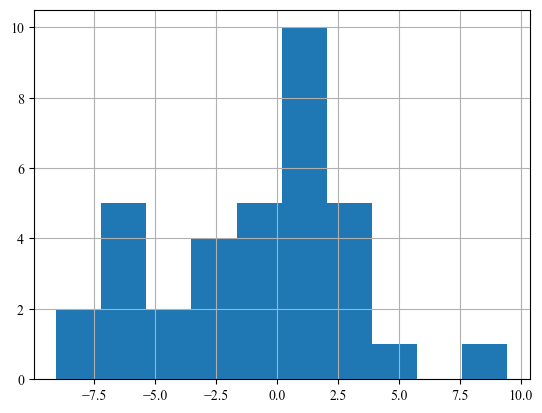

In [26]:
(y_test-result_df).sort_values(ascending=False).hist()

<Axes: >

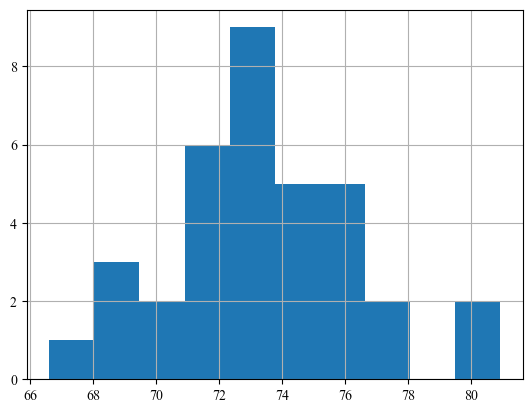

In [27]:
result_df.sort_values(ascending=False).hist()

In [28]:
(y_test-result_df).describe()

count    35.000000
mean     -0.791942
std       4.145662
min      -9.068224
25%      -3.705578
50%      -0.376820
75%       1.657658
max       9.441328
dtype: float64

In [29]:
outlier = (y_test-result_df)>3
X_test[outlier]


,,,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,StandingTackle,shooting_technique,SlidingTackle
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
241096,S. Tonali,2020,72.0,61.0,70.0,77.0,61.0,76.0,70.0,67.0,80.0,76.0,...,79.0,68.0,76.0,73.0,61.0,74.0,65.0,71.0,66.4,70.0
241042,O. Skipp,2020,52.0,41.0,51.0,73.0,35.0,60.0,48.0,42.0,66.0,68.0,...,57.0,45.0,67.0,61.0,50.0,62.0,54.0,69.0,43.6,63.0
246764,M. Camara,2021,53.0,51.0,51.0,71.0,49.0,70.0,56.0,51.0,68.0,72.0,...,58.0,53.0,75.0,68.0,60.0,66.0,54.0,71.0,53.4,68.0
242633,M. Frendrup,2021,46.0,39.0,52.0,70.0,31.0,60.0,51.0,40.0,67.0,66.0,...,66.0,38.0,63.0,63.0,44.0,45.0,39.0,68.0,40.0,64.0
242619,C. Doucouré,2020,51.0,35.0,57.0,71.0,42.0,65.0,44.0,42.0,63.0,67.0,...,68.0,36.0,53.0,65.0,51.0,70.0,46.0,68.0,42.8,61.0
239529,F. Onyeka,2021,53.0,62.0,63.0,71.0,53.0,66.0,56.0,42.0,67.0,73.0,...,80.0,49.0,74.0,72.0,67.0,66.0,48.0,73.0,53.4,68.0


In [30]:
y_test[outlier]

ID      Name         FIFA
241096  S. Tonali    2020    86.0
241042  O. Skipp     2020    77.0
246764  M. Camara    2021    78.0
242633  M. Frendrup  2021    72.0
242619  C. Doucouré  2020    78.0
239529  F. Onyeka    2021    75.0
Name: target, dtype: float64

In [31]:
result_df[outlier]

ID      Name         FIFA
241096  S. Tonali    2020    76.558672
241042  O. Skipp     2020    73.512751
246764  M. Camara    2021    72.419800
242633  M. Frendrup  2021    68.287214
242619  C. Doucouré  2020    74.208399
239529  F. Onyeka    2021    71.162260
dtype: float64

In [32]:
(y_test/result_df).describe()

count    35.000000
mean      0.988994
std       0.056818
min       0.874172
25%       0.949416
50%       0.994721
75%       1.022753
max       1.123321
dtype: float64

In [33]:
(y_test/result_df).describe()

count    35.000000
mean      0.988994
std       0.056818
min       0.874172
25%       0.949416
50%       0.994721
75%       1.022753
max       1.123321
dtype: float64

In [34]:
np.corrcoef(y_test,result_df)

array([[1.        , 0.64965909],
       [0.64965909, 1.        ]])

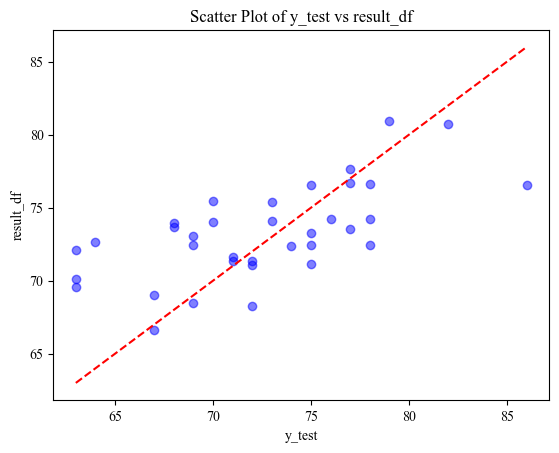

In [35]:
import matplotlib.pyplot as plt
plt.scatter(y_test, result_df, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Diagonal line')

plt.title('Scatter Plot of y_test vs result_df')
plt.xlabel('y_test')
plt.ylabel('result_df')
plt.show()

In [36]:
result_df = result_df.sort_values(ascending=False)

In [37]:
result_df.head(50)

ID      Name              FIFA
240679  T. Koopmeiners    2021    80.922399
230258  Rosberto Dourado  2021    80.754642
237520  M. Camara         2020    77.642674
241707  P. Gueye          2021    76.698996
247495  Moncayola         2021    76.623323
241096  S. Tonali         2020    76.558672
244238  J. Bijol          2020    76.536485
253251  J. Morel          2021    75.470580
234319  L. Travis         2021    75.407755
230918  T. Chalobah       2020    74.240435
242619  C. Doucouré       2020    74.208399
236298  E. Atuesta        2020    74.115712
241419  M. Bird           2021    73.983632
250839  J. Pretell        2021    73.944914
242214  J. Sands          2020    73.644943
241042  O. Skipp          2020    73.512751
245209  M. Sadílek        2020    73.292887
246594  H. Massengo       2020    73.045519
245903  H. White          2021    72.632318
254909  O. Dorley         2021    72.428878
244692  J. Christensen    2021    72.427524
246764  M. Camara         2021    72.419800
2

In [38]:
bool_ = (result_df>=TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

1


ID      Name              FIFA
230258  Rosberto Dourado  2021    80.754642
dtype: float64

In [39]:
bool_ = (result_df<TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

1


ID      Name       FIFA
241096  S. Tonali  2020    76.558672
dtype: float64

In [40]:
bool_ = (result_df>TARGET_OVERALL)&(y_test<=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

1


ID      Name            FIFA
240679  T. Koopmeiners  2021    80.922399
dtype: float64

In [41]:
bool_ = (result_df<TARGET_OVERALL)&(y_test<TARGET_OVERALL)
print(bool_.sum())
result_df[bool_].sort_values().tail(20)

32


ID      Name            FIFA
242280  L. Ferguson     2021    72.391797
246764  M. Camara       2021    72.419800
244692  J. Christensen  2021    72.427524
254909  O. Dorley       2021    72.428878
245903  H. White        2021    72.632318
246594  H. Massengo     2020    73.045519
245209  M. Sadílek      2020    73.292887
241042  O. Skipp        2020    73.512751
242214  J. Sands        2020    73.644943
250839  J. Pretell      2021    73.944914
241419  M. Bird         2021    73.983632
236298  E. Atuesta      2020    74.115712
242619  C. Doucouré     2020    74.208399
230918  T. Chalobah     2020    74.240435
234319  L. Travis       2021    75.407755
253251  J. Morel        2021    75.470580
244238  J. Bijol        2020    76.536485
247495  Moncayola       2021    76.623323
241707  P. Gueye        2021    76.698996
237520  M. Camara       2020    77.642674
dtype: float64

In [42]:
from sklearn.metrics import  classification_report
print(classification_report(y_test>75, result_df>75))

              precision    recall  f1-score   support

       False       0.77      0.80      0.78        25
        True       0.44      0.40      0.42        10

    accuracy                           0.69        35
   macro avg       0.61      0.60      0.60        35
weighted avg       0.68      0.69      0.68        35

